## Numerical integration on tabulated data: Newton–Cotes rules and Gauss quadrature

### 1) Goal
Approximate the definite integral
$$
I = \int_{-1}^{1} f(x)\,dx
$$
from tabulated values of $f(x)$ using:
1. Rectangle rule (left / right / midpoint)
2. Trapezoidal rule
3. Simpson’s rule
4. Gauss–Legendre quadrature

When needed we use a natural cubic spline interpolant $S(x)$

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
x = np.array([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0], dtype=float)
y = np.array([-0.333, 0.0, -0.125, -0.056, 0.0, 0.046, 0.083, 0.115, 0.143], dtype=float)

assert np.allclose(np.diff(x), x[1] - x[0])
a, b = float(x[0]), float(x[-1])
h_data = float(x[1] - x[0])

pd.DataFrame({"x": x, "f(x)": y})


,x,f(x)
0,-1.00,-0.333
1,-0.75,0.000
2,-0.50,-0.125
3,-0.25,-0.056
4,0.00,0.000
5,0.25,0.046
6,0.50,0.083
7,0.75,0.115
8,1.00,0.143


### 2) Quadrature formulas 

Let $x_i=a+ih$, $i=0,\dots,N$, where $h=(b-a)/N$.

#### Rectangle rule
Left:
$$
I \approx h\sum_{i=0}^{N-1} f(x_i)
$$
Right:
$$
I \approx h\sum_{i=1}^{N} f(x_i)
$$
Midpoint:
$$
I \approx h\sum_{i=0}^{N-1} f\!\left(x_i+\frac{h}{2}\right)
$$

#### Trapezoidal rule
$$
I \approx h\left(\frac{f(x_0)+f(x_N)}{2} + \sum_{i=1}^{N-1} f(x_i)\right)
$$

#### Simpson’s rule
$$
I \approx \frac{h}{3}\left[f(x_0)+f(x_N) + 4\sum_{i\ \text{odd}} f(x_i) + 2\sum_{i\ \text{even},\, i\neq 0,N} f(x_i)\right]
$$

#### Gauss–Legendre
On $[-1,1]$:
$$
\int_{-1}^{1} f(t)\,dt \approx \sum_{k=1}^{m} w_k f(t_k)
$$
Map to $[a,b]$ using $x=\frac{a+b}{2}+\frac{b-a}{2}t$:
$$
\int_a^b f(x)\,dx \approx \frac{b-a}{2}\sum_{k=1}^{m} w_k f\!\left(\frac{a+b}{2}+\frac{b-a}{2}t_k\right).
$$


In [26]:
def spline_natural_cubic(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x) - 1
    h = np.diff(x)

    acoef = y.copy()
    alpha = np.zeros(n + 1, dtype=float)
    for i in range(1, n):
        alpha[i] = (3 / h[i]) * (acoef[i + 1] - acoef[i]) - (3 / h[i - 1]) * (acoef[i] - acoef[i - 1])

    l = np.ones(n + 1, dtype=float)
    mu = np.zeros(n + 1, dtype=float)
    z = np.zeros(n + 1, dtype=float)

    for i in range(1, n):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]

    ccoef = np.zeros(n + 1, dtype=float)
    bcoef = np.zeros(n, dtype=float)
    dcoef = np.zeros(n, dtype=float)

    for j in range(n - 1, -1, -1):
        ccoef[j] = z[j] - mu[j] * ccoef[j + 1]
        bcoef[j] = (acoef[j + 1] - acoef[j]) / h[j] - h[j] * (ccoef[j + 1] + 2 * ccoef[j]) / 3
        dcoef[j] = (ccoef[j + 1] - ccoef[j]) / (3 * h[j])

    return {"x": x, "a": acoef[:-1], "b": bcoef, "c": ccoef[:-1], "d": dcoef}

def spline_eval(spl, xq):
    xk = spl["x"]
    acoef = spl["a"]; bcoef = spl["b"]; ccoef = spl["c"]; dcoef = spl["d"]
    xq = np.asarray(xq, dtype=float)

    idx = np.searchsorted(xk, xq, side="right") - 1
    idx = np.clip(idx, 0, len(acoef) - 1)

    t = xq - xk[idx]
    return acoef[idx] + bcoef[idx] * t + ccoef[idx] * t**2 + dcoef[idx] * t**3

def spline_integral(spl, A, B):
    xk = spl["x"]
    acoef = spl["a"]; bcoef = spl["b"]; ccoef = spl["c"]; dcoef = spl["d"]
    A = float(A); B = float(B)
    if A == B:
        return 0.0
    if A > B:
        return -spline_integral(spl, B, A)

    A = max(A, float(xk[0]))
    B = min(B, float(xk[-1]))

    ia = np.searchsorted(xk, A, side="right") - 1
    ib = np.searchsorted(xk, B, side="right") - 1
    ia = int(np.clip(ia, 0, len(acoef) - 1))
    ib = int(np.clip(ib, 0, len(acoef) - 1))

    def seg_int(j, t0, t1):
        return (
            acoef[j] * (t1 - t0)
            + bcoef[j] * (t1**2 - t0**2) / 2
            + ccoef[j] * (t1**3 - t0**3) / 3
            + dcoef[j] * (t1**4 - t0**4) / 4
        )

    total = 0.0
    if ia == ib:
        return seg_int(ia, A - xk[ia], B - xk[ia])

    total += seg_int(ia, A - xk[ia], xk[ia + 1] - xk[ia])
    for j in range(ia + 1, ib):
        total += seg_int(j, 0.0, xk[j + 1] - xk[j])
    total += seg_int(ib, 0.0, B - xk[ib])
    return total


In [27]:
spl = spline_natural_cubic(x, y)
I_ref = spline_integral(spl, a, b)
I_ref


np.float64(0.0012255154639175155)

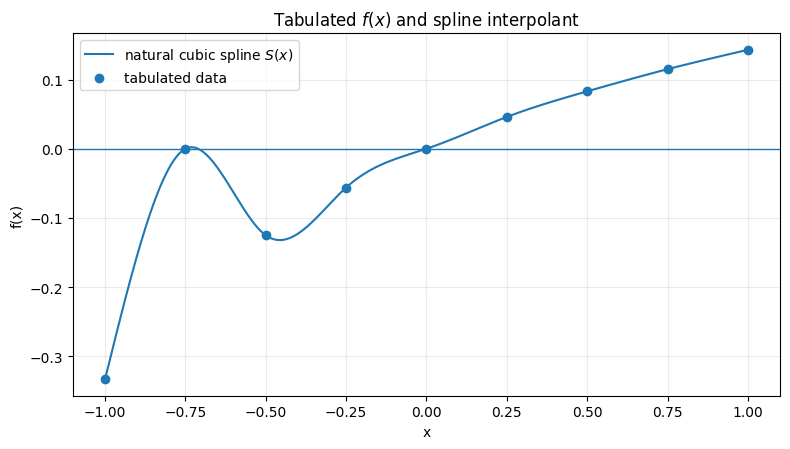

In [28]:
xx = np.linspace(a, b, 800)
yy = spline_eval(spl, xx)

plt.figure(figsize=(8, 4.6))
plt.plot(xx, yy, label="natural cubic spline $S(x)$")
plt.scatter(x, y, zorder=3, label="tabulated data")
plt.axhline(0, linewidth=1)
plt.title("Tabulated $f(x)$ and spline interpolant")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


### 4) Implementations: composite Newton–Cotes rules

We implement the rules for a callable $f$ on $[a,b]$ with $N$ subintervals.
This allows:
- using $N=8$ to match the given grid,
- refining $N$ to study error behavior against $I_{\mathrm{ref}}$.


In [29]:
def composite_rectangle(f, a, b, N, mode="left"):
    a = float(a); b = float(b)
    N = int(N)
    h = (b - a) / N

    if mode == "left":
        xk = a + h * np.arange(N)
        return h * np.sum(f(xk))
    if mode == "right":
        xk = a + h * np.arange(1, N + 1)
        return h * np.sum(f(xk))
    if mode == "midpoint":
        xk = a + h * (np.arange(N) + 0.5)
        return h * np.sum(f(xk))

    raise ValueError("mode must be in {'left','right','midpoint'}")

def composite_trapezoid(f, a, b, N):
    a = float(a); b = float(b)
    N = int(N)
    h = (b - a) / N
    xk = a + h * np.arange(N + 1)
    fk = f(xk)
    return h * (0.5 * fk[0] + np.sum(fk[1:-1]) + 0.5 * fk[-1])

def composite_simpson(f, a, b, N):
    a = float(a); b = float(b)
    N = int(N)
    if N % 2 != 0:
        raise ValueError("Simpson requires even N (number of subintervals).")

    h = (b - a) / N
    xk = a + h * np.arange(N + 1)
    fk = f(xk)

    odd = fk[1:-1:2]
    even = fk[2:-1:2]
    return (h / 3) * (fk[0] + fk[-1] + 4 * np.sum(odd) + 2 * np.sum(even))


### 5) Gauss–Legendre quadrature (2, 3, 4 points)

We implement:
- single-panel Gauss on $[a,b]$,
- composite Gauss with $N$ panels (apply Gauss in each panel).


In [30]:
def gauss_legendre_nodes_weights(m):
    m = int(m)
    if m == 2:
        t = np.array([-1/np.sqrt(3), 1/np.sqrt(3)], dtype=float)
        w = np.array([1.0, 1.0], dtype=float)
    elif m == 3:
        t = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)], dtype=float)
        w = np.array([5/9, 8/9, 5/9], dtype=float)
    elif m == 4:
        t = np.array([-0.8611363115940526, -0.3399810435848563,
                      0.3399810435848563,  0.8611363115940526], dtype=float)
        w = np.array([0.34785484513745385, 0.6521451548625461,
                      0.6521451548625461,  0.34785484513745385], dtype=float)
    else:
        raise ValueError("m must be 2, 3, or 4.")
    return t, w

def gauss_legendre(f, a, b, m):
    a = float(a); b = float(b)
    t, w = gauss_legendre_nodes_weights(m)
    xm = 0.5 * (a + b)
    xr = 0.5 * (b - a)
    xg = xm + xr * t
    return xr * np.sum(w * f(xg))

def composite_gauss_legendre(f, a, b, N, m):
    a = float(a); b = float(b)
    N = int(N)
    h = (b - a) / N
    total = 0.0
    for i in range(N):
        ai = a + i * h
        bi = ai + h
        total += gauss_legendre(f, ai, bi, m)
    return total


### 6) “Grid-level” estimates ($N=8$, $h=0.25$)

Rules using only the table:
- left/right rectangle, trapezoid, Simpson.

Rules requiring off-grid values:
- midpoint rectangles and Gauss (use spline $S(x)$).


In [31]:
def rectangle_left_from_table(x, y):
    h = float(x[1] - x[0])
    return h * float(np.sum(y[:-1]))

def rectangle_right_from_table(x, y):
    h = float(x[1] - x[0])
    return h * float(np.sum(y[1:]))

def trapezoid_from_table(x, y):
    h = float(x[1] - x[0])
    return h * float(0.5*y[0] + np.sum(y[1:-1]) + 0.5*y[-1])

def simpson_from_table(x, y):
    h = float(x[1] - x[0])
    N = len(x) - 1
    if N % 2 != 0:
        raise ValueError("Simpson requires an even number of subintervals.")
    return (h/3) * float(y[0] + y[-1] + 4*np.sum(y[1:-1:2]) + 2*np.sum(y[2:-1:2]))

f_spline = lambda z: spline_eval(spl, z)
N_data = len(x) - 1


In [32]:
res = []

res.append(("Rectangle (left, table)", rectangle_left_from_table(x, y)))
res.append(("Rectangle (right, table)", rectangle_right_from_table(x, y)))
res.append(("Trapezoid (table)", trapezoid_from_table(x, y)))
res.append(("Simpson (table)", simpson_from_table(x, y)))

res.append(("Rectangle (midpoint, spline)", composite_rectangle(f_spline, a, b, N_data, mode="midpoint")))
res.append(("Gauss 2-pt (composite N=8, spline)", composite_gauss_legendre(f_spline, a, b, N_data, m=2)))
res.append(("Gauss 3-pt (composite N=8, spline)", composite_gauss_legendre(f_spline, a, b, N_data, m=3)))
res.append(("Gauss 4-pt (composite N=8, spline)", composite_gauss_legendre(f_spline, a, b, N_data, m=4)))

rows = []
for name, val in res:
    rows.append({
        "method": name,
        "I approx": float(val),
        "abs error vs I_ref": float(abs(val - I_ref)),
    })

summary_N8 = pd.DataFrame(rows).sort_values("abs error vs I_ref")
summary_N8


,method,I approx,abs error vs I_ref
7,"Gauss 4-pt (composite N=8, spline)",0.001226,0.000000e+00
5,"Gauss 2-pt (composite N=8, spline)",0.001226,3.469447e-18
6,"Gauss 3-pt (composite N=8, spline)",0.001226,2.428613e-17
4,"Rectangle (midpoint, spline)",0.005838,4.612758e-03
2,Trapezoid (table),-0.008000,9.225515e-03
3,Simpson (table),0.012167,1.094115e-02
1,"Rectangle (right, table)",0.051500,5.027448e-02
0,"Rectangle (left, table)",-0.067500,6.872552e-02


### 7) Convergence study (error vs step size)

Treat the spline $S(x)$ as the underlying function and refine $N$:
$$
h=\frac{b-a}{N},\qquad \text{error}(h)=|I_h-I_{\mathrm{ref}}|.
$$

We estimate empirical order $p$ from the slope on a log–log scale.


In [33]:
def safe_log(x, floor=1e-300):
    x = np.asarray(x, dtype=float)
    return np.log(np.maximum(x, floor))

Ns = 2 ** np.arange(1, 10)  # 2..512
hs = (b - a) / Ns

methods = {
    "Rect (left)": lambda N: composite_rectangle(f_spline, a, b, N, mode="left"),
    "Rect (midpoint)": lambda N: composite_rectangle(f_spline, a, b, N, mode="midpoint"),
    "Trapezoid": lambda N: composite_trapezoid(f_spline, a, b, N),
    "Simpson": lambda N: composite_simpson(f_spline, a, b, N if N % 2 == 0 else N + 1),
    "Gauss m=2": lambda N: composite_gauss_legendre(f_spline, a, b, N, m=2),
    "Gauss m=3": lambda N: composite_gauss_legendre(f_spline, a, b, N, m=3),
    "Gauss m=4": lambda N: composite_gauss_legendre(f_spline, a, b, N, m=4),
}

err = {name: [] for name in methods}
Ivals = {name: [] for name in methods}

for N in Ns:
    for name, quad in methods.items():
        Ih = quad(int(N))
        Ivals[name].append(Ih)
        err[name].append(abs(Ih - I_ref))

for name in methods:
    err[name] = np.array(err[name], dtype=float)
    Ivals[name] = np.array(Ivals[name], dtype=float)


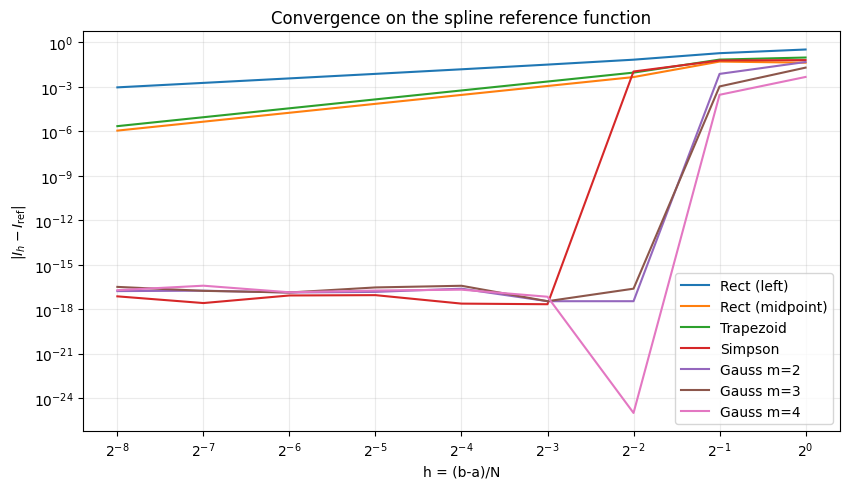

In [38]:
plt.figure(figsize=(8.6, 5.0))
for name in methods:
    plt.plot(hs, np.maximum(err[name], 1e-25), label=name)

plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.xlabel("h = (b-a)/N")
plt.ylabel(r"$|I_h - I_{\mathrm{ref}}|$")
plt.title("Convergence on the spline reference function")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
def estimate_order(hs, errs, tail=5):
    hs = np.asarray(hs, dtype=float)
    errs = np.asarray(errs, dtype=float)
    hs_t = hs[-tail:]
    errs_t = errs[-tail:]
    return float(np.polyfit(np.log(hs_t), safe_log(errs_t), 1)[0])

order_rows = []
for name in methods:
    order_rows.append({
        "method": name,
        "estimated order p (last points)": estimate_order(hs, err[name], tail=5),
        "error at N=8": float(err[name][np.where(Ns == 8)[0][0]]),
        "error at N=64": float(err[name][np.where(Ns == 64)[0][0]]),
    })

orders = pd.DataFrame(order_rows).sort_values("estimated order p (last points)", ascending=False)
orders


,method,estimated order p (last points),error at N=8,error at N=64
1,Rect (midpoint),2.000000,4.612758e-03,7.207434e-05
2,Trapezoid,2.000000,9.225515e-03,1.441487e-04
0,Rect (left),1.012347,6.872552e-02,7.581649e-03
5,Gauss m=3,0.126549,2.428613e-17,2.949030e-17
4,Gauss m=2,0.081105,3.469447e-18,1.474515e-17
6,Gauss m=4,-0.086496,0.000000e+00,1.821460e-17
3,Simpson,-0.148347,1.094115e-02,8.890458e-18
